Author: Alassane Watt -- alassane.watt@student.ecp.fr


Import statements

In [1]:
import torch
import torch.nn as nn
import json
import os
import matplotlib.pyplot as plt
from neuronlp2.io.alphabet import Alphabet
from neuronlp2.models import BiRecurrentConv
from experiments.ner import eval
from neuronlp2.io import get_logger, conll03_data, CoNLL03Writer, iterate_data
from gensim.models.word2vec import Word2Vec
import gensim
device = torch.device('cuda', 0) if torch.cuda.is_available() else torch.device('cpu')


The following cell implements a pipeline class performing the main following tasks:
- dataset statistics computation
- ner model evaluation.

In [3]:
class Pipeline:
    """ This is a class performing the pipeline consisting of dataset statistics computation and ner model evaluation.
    """
    def __init__(self, train_path, model_dir):
        self.train_path = train_path
#         self.test_path = test_path
        self.model_dir = model_dir
        with open(self.train_path) as f:
            self.train_data = [line.strip() for line in f.readlines()]
        
        self.result_path = os.path.join(self.model_dir, 'results')
        if not os.path.exists(self.result_path):
            os.makedirs(self.result_path)
        
    
    def compute_stats(self):
        # n_sentences
        n_sentences = 0
        for line in self.train_data:
            if line == "":
                n_sentences += 1
        self.n_sentences = n_sentences
        
        # n_words
        self.n_words = len([line for line in self.train_data if line != ''])
        
        #n_unique_words
        self.n_unique_words = len(set([line.split(" ")[1] for line in self.train_data if line != '']))
        
        #tags
        self.tags = set([line.split(" ")[4] for line in self.train_data if line != ''])
        
        # n_tokens per sentence
        empty_indices = [i for i, line in enumerate(self.train_data) if line == ""]
        i = 0
        sentences_train = []
        prev_i = 0
        for i in empty_indices:
            sentences_train.append(self.train_data[prev_i:i])
            prev_i = i + 1
        
        self.n_tokens_per_sentence = [len(s) for s in sentences_train]
    
    def print_stats(self):
        self.compute_stats()
        print("Number of sentences: ", self.n_sentences)
        print("Number of words: ", self.n_words)
        print("Number of unique words: ", self.n_unique_words)
        print("Number of tags: ", len(self.tags))
        print("Different tags: ", self.tags)
        
        plt.hist(self.n_tokens_per_sentence, bins=50)
        plt.title('Token per sentence')
        plt.xlabel('Len (number of token)')
        plt.ylabel('# samples')
        plt.show()
    
    def load_model(self):
        hyps_path = os.path.join(self.model_dir, "config.json")
        with open(hyps_path) as f:
            hyps = json.load(f)
        
        dropout = hyps['dropout']
        crf = hyps['crf']
        bigram = hyps['bigram']
        embedd_dim = hyps['embedd_dim']
        char_dim = hyps['char_dim']
        mode = hyps['rnn_mode']
        hidden_size = hyps['hidden_size']
        out_features = hyps['out_features']
        num_layers = hyps['num_layers']
        p_in = hyps['p_in']
        p_out = hyps['p_out']
        p_rnn = hyps['p_rnn']
        activation = hyps['activation']
        
        alphabets_dir = os.path.join(self.model_dir, "alphabets")
        self.word_alphabet = Alphabet('word', defualt_value=True, singleton=True)
        self.word_alphabet.load(alphabets_dir)

        self.char_alphabet = Alphabet('character', defualt_value=True)
        self.char_alphabet.load(alphabets_dir)

        self.ner_alphabet = Alphabet('ner')
        self.ner_alphabet.load(alphabets_dir)
        num_labels = self.ner_alphabet.size()

        self.pos_alphabet = Alphabet('pos')
        self.pos_alphabet.load(alphabets_dir)

        self.chunk_alphabet = Alphabet('chunk')
        self.chunk_alphabet.load(alphabets_dir)

        self.writer = CoNLL03Writer(self.word_alphabet, self.char_alphabet, self.pos_alphabet, self.chunk_alphabet, self.ner_alphabet)
        
        word_table = None
        model_dict_path = os.path.join(self.model_dir, "model.pt")
        model_state_dict = torch.load(model_dict_path)

        model = BiRecurrentConv(embedd_dim, self.word_alphabet.size(), char_dim, self.char_alphabet.size(), mode, hidden_size, out_features, num_layers,
                                              num_labels, embedd_word=word_table, p_in=p_in, p_out=p_out, p_rnn=p_rnn, activation=activation)

        model.load_state_dict(model_state_dict)
        self.model = model.to(device)
        self.model.eval()        
        
    def get_results(self, test_path): 
        outfile = os.path.join(self.result_path, 'pred_test')
        scorefile = os.path.join(self.result_path, 'score_test')
        data_test = conll03_data.read_data(test_path, self.word_alphabet, self.char_alphabet, self.pos_alphabet, self.chunk_alphabet, self.ner_alphabet)

        test_acc, test_precision, test_recall, test_f1 = eval(data_test, self.model, self.writer, outfile, scorefile, device)
        return test_acc, test_precision, test_recall, test_f1

        

In the following we evaluate 10 configurations of the NeuroNLP2 NER model:
 - w2v embeddings trained on small press corpus + ner trained on press fra4_ID
 - w2v embeddings trained on med corpus + ner trained on emea
 - w2v embeddings trained on med corpus + ner trained on medline
 - w2v embeddings trained on full press corpus + ner trained on fra4
 - fasttext embeddings trained on small press corpus + ner trained on fra4
 - fasttext embeddings trained on full press corpus + ner trained on fra4
 - fasttext embeddings trained on med corpus + ner trained on emea
 - fasttext embeddings trained on med corpus + ner trained on medline
 - fasttext embeddings trained on med corpus + ner trained on fra4 press
 - fasttext embeddings trained on small press corpus + ner trained on emea

__Plan:__

1) Experimentations <br>
2) Performance comparison<br>

# Experimentations

## w2v embeddings trained on small press corpus + ner trained on press fra4_ID

Number of sentences:  35723
Number of words:  1156339
Number of unique words:  37863
Number of tags:  11
Different tags:  {'i-func', 'b-org', 'b-pers', 'O', 'b-loc', 'b-func', 'i-loc', 'i-prod', 'i-pers', 'b-prod', 'i-org'}


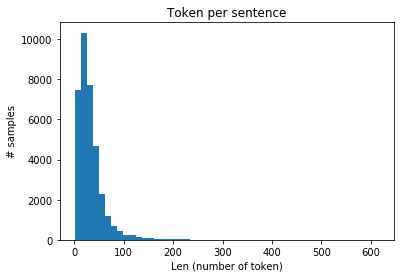

In [14]:
train_path = "experiments/data/QUAERO_FrenchPress/fra4_ID.train"
model_dir = "experiments/models/ner/ner_w2v_sg_p_small_fra4"
sg_pipeline = Pipeline(train_path, model_dir)
sg_pipeline.print_stats()

In [15]:
# the pattern for get_results's first parameter is embedmodel_corpus_nercorpus
sg_pipeline.load_model()
test_path = "experiments/data/QUAERO_FrenchPress/fra4_ID.test"
test_acc, test_precision, test_recall, test_f1 = sg_pipeline.get_results(test_path)
print("Evaluation for w2v|QUAERO_FrenchPress small|fra4_ID.test")
print('test acc: %.2f%%, precision: %.2f%%, recall: %.2f%%, F1: %.2f%%' % (test_acc, test_precision, test_recall, test_f1))


Reading data from experiments/data/QUAERO_FrenchPress/fra4_ID.test
Total number of data: 2880
Evaluation for w2v|QUAERO_FrenchPress small|fra4_ID.test
test acc: 97.29%, precision: 69.52%, recall: 64.44%, F1: 66.88%


## w2v embeddings trained on med corpus + ner trained on emea

Number of sentences:  738
Number of words:  15339
Number of unique words:  2599
Number of tags:  21
Different tags:  {'B-DISO', 'O', 'I-ANAT', 'B-PHEN', 'I-PROC', 'B-CHEM', 'I-GEOG', 'I-DEVI', 'B-GEOG', 'I-LIVB', 'I-PHYS', 'B-PROC', 'I-OBJC', 'B-LIVB', 'B-PHYS', 'B-DEVI', 'B-ANAT', 'I-PHEN', 'B-OBJC', 'I-DISO', 'I-CHEM'}


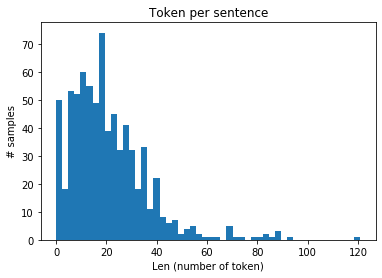

In [16]:
train_path = "experiments/data/QUAERO_FrenchMed/EMEA/EMEAtrain_layer1_ID.conll"
model_dir = "experiments/models/ner/ner_w2v_sg_emea"
sg_pipeline = Pipeline(train_path, model_dir)
sg_pipeline.print_stats()

In [17]:
# the pattern for get_results's first parameter is embedmodel_corpus_nercorpus
sg_pipeline.load_model()
test_path = "experiments/data/QUAERO_FrenchMed/EMEA/EMEAtest_layer1_ID.conll"
test_acc, test_precision, test_recall, test_f1 = sg_pipeline.get_results(test_path)
print("Evaluation for w2v|QUAERO_FrenchMed|EMEAtest_layer1_ID.conll")
print('test acc: %.2f%%, precision: %.2f%%, recall: %.2f%%, F1: %.2f%%' % (test_acc, test_precision, test_recall, test_f1))


Reading data from experiments/data/QUAERO_FrenchMed/EMEA/EMEAtest_layer1_ID.conll
Total number of data: 578
Evaluation for w2v|QUAERO_FrenchMed|EMEAtest_layer1_ID.conll
test acc: 84.05%, precision: 47.17%, recall: 35.24%, F1: 40.34%


## w2v embeddings trained on med corpus + ner trained on medline

Number of sentences:  835
Number of words:  11525
Number of unique words:  3862
Number of tags:  21
Different tags:  {'B-DISO', 'O', 'I-ANAT', 'B-PHEN', 'I-PROC', 'B-CHEM', 'I-GEOG', 'I-DEVI', 'B-GEOG', 'I-LIVB', 'I-PHYS', 'B-PROC', 'I-OBJC', 'B-LIVB', 'B-PHYS', 'B-DEVI', 'B-ANAT', 'I-PHEN', 'B-OBJC', 'I-DISO', 'I-CHEM'}


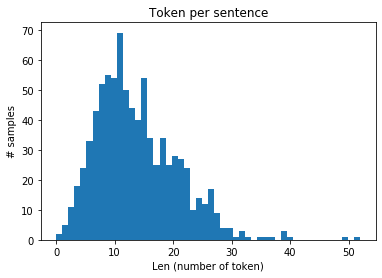

In [18]:
train_path = "experiments/data/QUAERO_FrenchMed/MEDLINE/MEDLINEtrain_layer1_ID.conll"
model_dir = "experiments/models/ner/ner_w2v_sg_medline"
sg_pipeline = Pipeline(train_path, model_dir)
sg_pipeline.print_stats()

In [19]:
# the pattern for get_results's first parameter is embedmodel_corpus_nercorpus
sg_pipeline.load_model()
test_path = "experiments/data/QUAERO_FrenchMed/MEDLINE/MEDLINEtest_layer1_ID.conll"
test_acc, test_precision, test_recall, test_f1 = sg_pipeline.get_results(test_path)
print("Evaluation for w2v|QUAERO_FrenchMed|Medlinetest_layer1_ID")
print('test acc: %.2f%%, precision: %.2f%%, recall: %.2f%%, F1: %.2f%%' % (test_acc, test_precision, test_recall, test_f1))


Reading data from experiments/data/QUAERO_FrenchMed/MEDLINE/MEDLINEtest_layer1_ID.conll
Total number of data: 835
Evaluation for w2v|QUAERO_FrenchMed|Medlinetest_layer1_ID
test acc: 72.69%, precision: 27.78%, recall: 23.28%, F1: 25.33%


## w2v embeddings trained on full press corpus + ner trained on fra4

Number of sentences:  35723
Number of words:  1156339
Number of unique words:  37863
Number of tags:  11
Different tags:  {'i-func', 'b-org', 'b-pers', 'O', 'b-loc', 'b-func', 'i-loc', 'i-prod', 'i-pers', 'b-prod', 'i-org'}


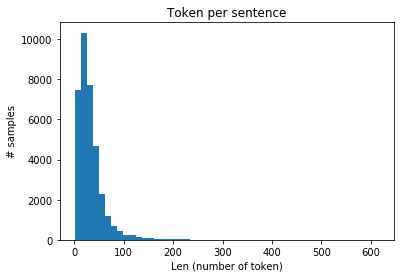

In [20]:
train_path = "experiments/data/QUAERO_FrenchPress/fra4_ID.train"
model_dir = "experiments/models/ner/ner_w2v_sg_p_fra4"
sg_pipeline = Pipeline(train_path, model_dir)
sg_pipeline.print_stats()

In [21]:
# the pattern for get_results's first parameter is embedmodel_corpus_nercorpus
sg_pipeline.load_model()
test_path = "experiments/data/QUAERO_FrenchPress/fra4_ID.test"
test_acc, test_precision, test_recall, test_f1 = sg_pipeline.get_results(test_path)
print("Evaluation for w2v|QUAERO_FrenchPress|fra4")
print('test acc: %.2f%%, precision: %.2f%%, recall: %.2f%%, F1: %.2f%%' % (test_acc, test_precision, test_recall, test_f1))


Reading data from experiments/data/QUAERO_FrenchPress/fra4_ID.test
Total number of data: 2880
Evaluation for w2v|QUAERO_FrenchPress|fra4
test acc: 97.50%, precision: 73.81%, recall: 66.02%, F1: 69.70%


## fasttext embeddings trained on small press corpus + ner trained on fra4

Number of sentences:  35723
Number of words:  1156339
Number of unique words:  37863
Number of tags:  11
Different tags:  {'i-func', 'b-org', 'b-pers', 'O', 'b-loc', 'b-func', 'i-loc', 'i-prod', 'i-pers', 'b-prod', 'i-org'}


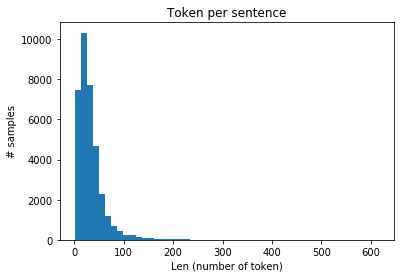

In [22]:
train_path = "experiments/data/QUAERO_FrenchPress/fra4_ID.train"
model_dir = "experiments/models/ner/ner_ft_sg_p_small_fra4"
sg_pipeline = Pipeline(train_path, model_dir)
sg_pipeline.print_stats()

In [23]:
# the pattern for get_results's first parameter is embedmodel_corpus_nercorpus
sg_pipeline.load_model()
test_path = "experiments/data/QUAERO_FrenchPress/fra4_ID.test"
test_acc, test_precision, test_recall, test_f1 = sg_pipeline.get_results(test_path)
print("Evaluation for fasttext|QUAERO_FrenchPress|fra4")
print('test acc: %.2f%%, precision: %.2f%%, recall: %.2f%%, F1: %.2f%%' % (test_acc, test_precision, test_recall, test_f1))


Reading data from experiments/data/QUAERO_FrenchPress/fra4_ID.test
Total number of data: 2880
Evaluation for fasttext|QUAERO_FrenchPress|fra4
test acc: 97.43%, precision: 72.46%, recall: 66.62%, F1: 69.41%


## fasttext embeddings trained on full press corpus + ner trained on fra4

Number of sentences:  35723
Number of words:  1156339
Number of unique words:  37863
Number of tags:  11
Different tags:  {'i-func', 'b-org', 'b-pers', 'O', 'b-loc', 'b-func', 'i-loc', 'i-prod', 'i-pers', 'b-prod', 'i-org'}


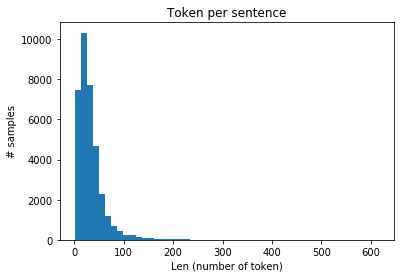

In [24]:
train_path = "experiments/data/QUAERO_FrenchPress/fra4_ID.train"
model_dir = "experiments/models/ner/ner_ft_sg_p_fra4"
sg_pipeline = Pipeline(train_path, model_dir)
sg_pipeline.print_stats()

In [25]:
# the pattern for get_results's first parameter is embedmodel_corpus_nercorpus
sg_pipeline.load_model()
test_path = "experiments/data/QUAERO_FrenchPress/fra4_ID.test"
test_acc, test_precision, test_recall, test_f1 = sg_pipeline.get_results(test_path)
print("Evaluation for fasttext|QUAERO_FrenchPress|fra4")
print('test acc: %.2f%%, precision: %.2f%%, recall: %.2f%%, F1: %.2f%%' % (test_acc, test_precision, test_recall, test_f1))


Reading data from experiments/data/QUAERO_FrenchPress/fra4_ID.test
Total number of data: 2880
Evaluation for fasttext|QUAERO_FrenchPress|fra4
test acc: 97.50%, precision: 73.43%, recall: 66.14%, F1: 69.59%


## fasttext embeddings trained on med corpus + ner trained on emea

Number of sentences:  738
Number of words:  15339
Number of unique words:  2599
Number of tags:  21
Different tags:  {'B-DISO', 'O', 'I-ANAT', 'B-PHEN', 'I-PROC', 'B-CHEM', 'I-GEOG', 'I-DEVI', 'B-GEOG', 'I-LIVB', 'I-PHYS', 'B-PROC', 'I-OBJC', 'B-LIVB', 'B-PHYS', 'B-DEVI', 'B-ANAT', 'I-PHEN', 'B-OBJC', 'I-DISO', 'I-CHEM'}


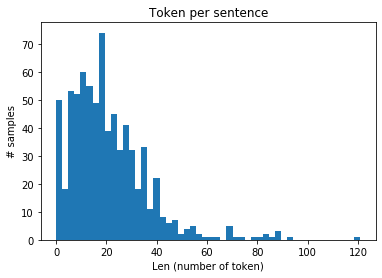

In [26]:
train_path = "experiments/data/QUAERO_FrenchMed/EMEA/EMEAtrain_layer1_ID.conll"
model_dir = "experiments/models/ner/ner_ft_sg_emea"
sg_pipeline = Pipeline(train_path, model_dir)
sg_pipeline.print_stats()

In [27]:
# the pattern for get_results's first parameter is embedmodel_corpus_nercorpus
sg_pipeline.load_model()
test_path = "experiments/data/QUAERO_FrenchMed/EMEA/EMEAtest_layer1_ID.conll"
test_acc, test_precision, test_recall, test_f1 = sg_pipeline.get_results(test_path)
print("Evaluation for fasttext|QUAERO_FrenchMed|emea")
print('test acc: %.2f%%, precision: %.2f%%, recall: %.2f%%, F1: %.2f%%' % (test_acc, test_precision, test_recall, test_f1))


Reading data from experiments/data/QUAERO_FrenchMed/EMEA/EMEAtest_layer1_ID.conll
Total number of data: 578
Evaluation for fasttext|QUAERO_FrenchMed|emea
test acc: 84.95%, precision: 61.07%, recall: 30.57%, F1: 40.75%


## fasttext embeddings trained on med corpus + ner trained on medline

Number of sentences:  835
Number of words:  11525
Number of unique words:  3862
Number of tags:  21
Different tags:  {'B-DISO', 'O', 'I-ANAT', 'B-PHEN', 'I-PROC', 'B-CHEM', 'I-GEOG', 'I-DEVI', 'B-GEOG', 'I-LIVB', 'I-PHYS', 'B-PROC', 'I-OBJC', 'B-LIVB', 'B-PHYS', 'B-DEVI', 'B-ANAT', 'I-PHEN', 'B-OBJC', 'I-DISO', 'I-CHEM'}


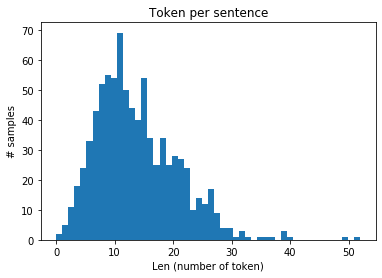

In [29]:
train_path = "experiments/data/QUAERO_FrenchMed/MEDLINE/MEDLINEtrain_layer1_ID.conll"
model_dir = "experiments/models/ner/ner_ft_sg_medline"
sg_pipeline = Pipeline(train_path, model_dir)
sg_pipeline.print_stats()

In [30]:
# the pattern for get_results's first parameter is embedmodel_corpus_nercorpus
sg_pipeline.load_model()
test_path = "experiments/data/QUAERO_FrenchMed/MEDLINE/MEDLINEtest_layer1_ID.conll"
test_acc, test_precision, test_recall, test_f1 = sg_pipeline.get_results(test_path)
print("Evaluation for fasttext|QUAERO_FrenchMed|Medline")
print('test acc: %.2f%%, precision: %.2f%%, recall: %.2f%%, F1: %.2f%%' % (test_acc, test_precision, test_recall, test_f1))


Reading data from experiments/data/QUAERO_FrenchMed/MEDLINE/MEDLINEtest_layer1_ID.conll
Total number of data: 835
Evaluation for fasttext|QUAERO_FrenchMed|Medline
test acc: 75.77%, precision: 42.71%, recall: 26.02%, F1: 32.34%


## fasttext embeddings trained on med corpus + ner trained on fra4 press

Number of sentences:  35723
Number of words:  1156339
Number of unique words:  37863
Number of tags:  11
Different tags:  {'i-func', 'b-org', 'b-pers', 'O', 'b-loc', 'b-func', 'i-loc', 'i-prod', 'i-pers', 'b-prod', 'i-org'}


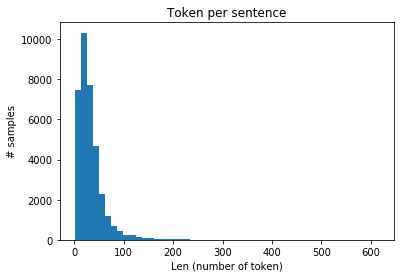

In [31]:
train_path = "experiments/data/QUAERO_FrenchPress/fra4_ID.train"
model_dir = "experiments/models/ner/ner_ft_sg_m-fra4"
sg_pipeline = Pipeline(train_path, model_dir)
sg_pipeline.print_stats()

In [32]:
# the pattern for get_results's first parameter is embedmodel_corpus_nercorpus
sg_pipeline.load_model()
test_path = "experiments/data/QUAERO_FrenchPress/fra4_ID.test"
test_acc, test_precision, test_recall, test_f1 = sg_pipeline.get_results(test_path)
print("Evaluation for fasttext|QUAERO_FrenchMed|Fra4")
print('test acc: %.2f%%, precision: %.2f%%, recall: %.2f%%, F1: %.2f%%' % (test_acc, test_precision, test_recall, test_f1))


Reading data from experiments/data/QUAERO_FrenchPress/fra4_ID.test
Total number of data: 2880
Evaluation for fasttext|QUAERO_FrenchMed|Fra4
test acc: 97.33%, precision: 73.10%, recall: 62.88%, F1: 67.60%


## fasttext embeddings trained on small press corpus + ner trained on emea

Number of sentences:  738
Number of words:  15339
Number of unique words:  2599
Number of tags:  21
Different tags:  {'B-DISO', 'O', 'I-ANAT', 'B-PHEN', 'I-PROC', 'B-CHEM', 'I-GEOG', 'I-DEVI', 'B-GEOG', 'I-LIVB', 'I-PHYS', 'B-PROC', 'I-OBJC', 'B-LIVB', 'B-PHYS', 'B-DEVI', 'B-ANAT', 'I-PHEN', 'B-OBJC', 'I-DISO', 'I-CHEM'}


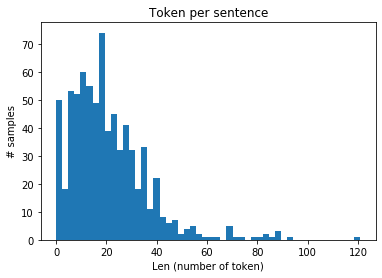

In [34]:
train_path = "experiments/data/QUAERO_FrenchMed/EMEA/EMEAtrain_layer1_ID.conll"
model_dir = "experiments/models/ner/ner_ft_sg_p_small-emea"
sg_pipeline = Pipeline(train_path, model_dir)
sg_pipeline.print_stats()

In [35]:
# the pattern for get_results's first parameter is embedmodel_corpus_nercorpus
sg_pipeline.load_model()
test_path = "experiments/data/QUAERO_FrenchMed/EMEA/EMEAtest_layer1_ID.conll"
test_acc, test_precision, test_recall, test_f1 = sg_pipeline.get_results(test_path)
print("Evaluation for fasttext|QUAERO_FrenchPress small|Emea")
print('test acc: %.2f%%, precision: %.2f%%, recall: %.2f%%, F1: %.2f%%' % (test_acc, test_precision, test_recall, test_f1))


Reading data from experiments/data/QUAERO_FrenchMed/EMEA/EMEAtest_layer1_ID.conll
Total number of data: 578
Evaluation for fasttext|QUAERO_FrenchPress small|Emea
test acc: 84.19%, precision: 54.85%, recall: 31.34%, F1: 39.89%


# Performance comparison

In [53]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [54]:
def compare_configs(args, labels=labels):
   
    n = len(args)
    df = pd.DataFrame({args[i][1]:args[i][0] for i in range(n)}, index=labels)
    ax = df.plot.bar(rot=0)
#     color={"Positive Values": "green", "Negative Values": "red"}

#     x = np.arange(len(labels))  # the label locations
#     width = 0.35  # the width of the bars
#     fig, ax = plt.subplots()
#     n = len(args)
#     rects = [ax.bar(x - width/n, args[i][0], width, label=args[i][1]) for i in range(n)]
    
# #     rects1 = ax.bar(x - width/n, w2v_p_small, width, label='Men')
# #     rects2 = ax.bar(x + width/n, women_means, width, label='Women')

#     # Add some text for labels, title and custom x-axis tick labels, etc.
#     ax.set_ylabel('Metrics')
#     ax.set_title('Metrics by type and config')
#     ax.set_xticks(x)
#     ax.set_xticklabels(labels)
#     ax.legend()
    
#     for rect in rects:
#         ax.bar_label(rect, padding=3)

#     fig.tight_layout()
    plt.title('Metrics by type and config')
    plt.show()

In [37]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1']
 
ft_p_small = [97.43, 72.46, 66.62, 69.41]
w2v_p_small = [97.29, 69.52, 64.44, 66.88]
ft_emea = [84.95, 61.07, 30.57, 40.75]
ft_medline = [75.77, 42.71, 26.02, 32.34]
ft_p = [97.50, 73.43, 66.14, 69.59]
w2v_p = [97.50, 73.81, 66.02, 69.70]
ft_m_fra4 = [97.33, 73.10, 62.88, 67.60]
ft_p_small_emea = [84.19, 54.85, 31.34, 39.89]
w2v_emea = [84.05, 47.17, 35.24, 40.34]
w2v_medline = [72.69, 27.78, 23.28, 25.33]

 ### The size of the corpus used to train word embedding
 use raw text samples of increasing sizes to train word embeddings

Comparing w2v trained on small press vs w2v trained on full press

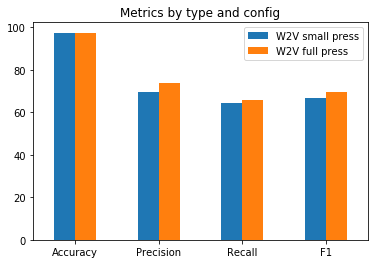

In [55]:
# args: a list of (results, label of results)
args = [(w2v_p_small, "W2V small press"), (w2v_p, "W2V full press")]
compare_configs(args)

Comparing Fasttext trained on small press vs Fasttext trained on full press

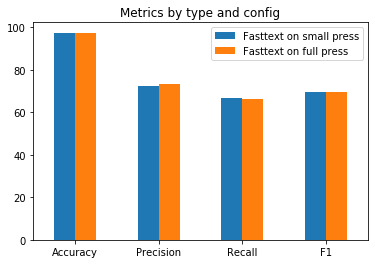

In [56]:
args = [(ft_p_small, "Fasttext on small press"), (ft_p, "Fasttext on full press")]
compare_configs(args)

__Mini-conclusion:__ The two previous graphs of this section show that embeddings trained on a bigger corpus improve the ner model performance.

### The word embedding model
use word embeddings created with word2vec skip-gram, fastText skip-gram

Comparing w2v trained on full press vs fasttext trained on full press

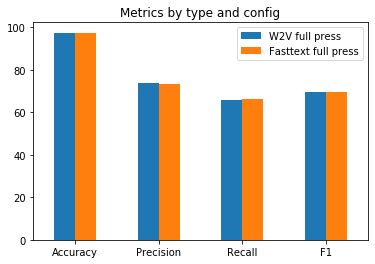

In [57]:
args = [(w2v_p, "W2V full press"), (ft_p, "Fasttext full press")]
compare_configs(args)

Comparing w2v trained on small press vs fasttext trained on small press

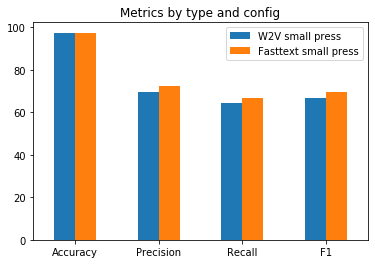

In [58]:
args = [(w2v_p_small, "W2V small press"), (ft_p_small, "Fasttext small press")]
compare_configs(args)

Comparing w2v trained on medical corpus vs fasttext trained on medical corpus and ner on emea

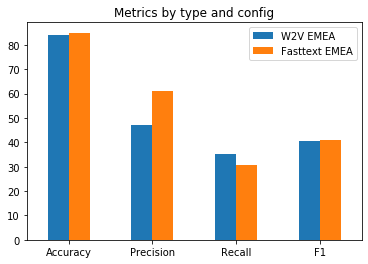

In [59]:
args = [(w2v_emea, "W2V EMEA"), (ft_emea, "Fasttext EMEA")]
compare_configs(args)

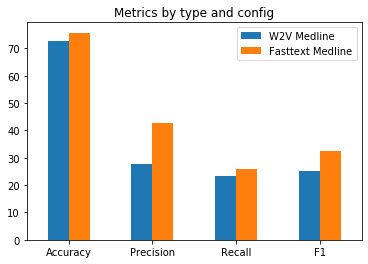

In [60]:
args = [(w2v_medline, "W2V Medline"), (ft_medline, "Fasttext Medline")]
compare_configs(args)

__Mini-conclusion:__ Fasttext seems to perform better than word2vec overall.

### The fit of the domain of the corpus used for named entity recognition and that of the word embeddings.
use word embeddings trained on a news corpus vs. a medical corpus of the same size

Comparing BETWEEN ner trained on press corpus with fasttext embeddings trained on medical corpus AND ner trained on press with fasttext embeddings trained on press

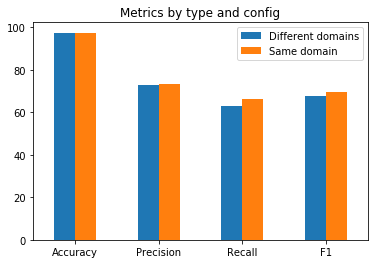

In [62]:
args = [(ft_m_fra4, "Different domains"), (ft_p, "Same domain")]
compare_configs(args)

Comparing BETWEEN ner trained on medical emea corpus with fasttext embeddings trained on small press corpus AND ner trained on medical emea corpus with fasttext embeddings trained on medical corpus

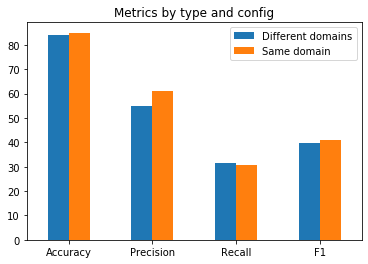

In [63]:
args = [(ft_p_small_emea, "Different domains"), (ft_emea, "Same domain")]
compare_configs(args)

__Mini_conclusion:__ As expected, having the word embeddings and the ner model trained on the same domain achieves higher performance than having them trained on different corpora.